In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as img
from collections import defaultdict
import collections
import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17107066685872993638
 xla_global_id: -1]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

!tar xzvf food-101.tar.gz

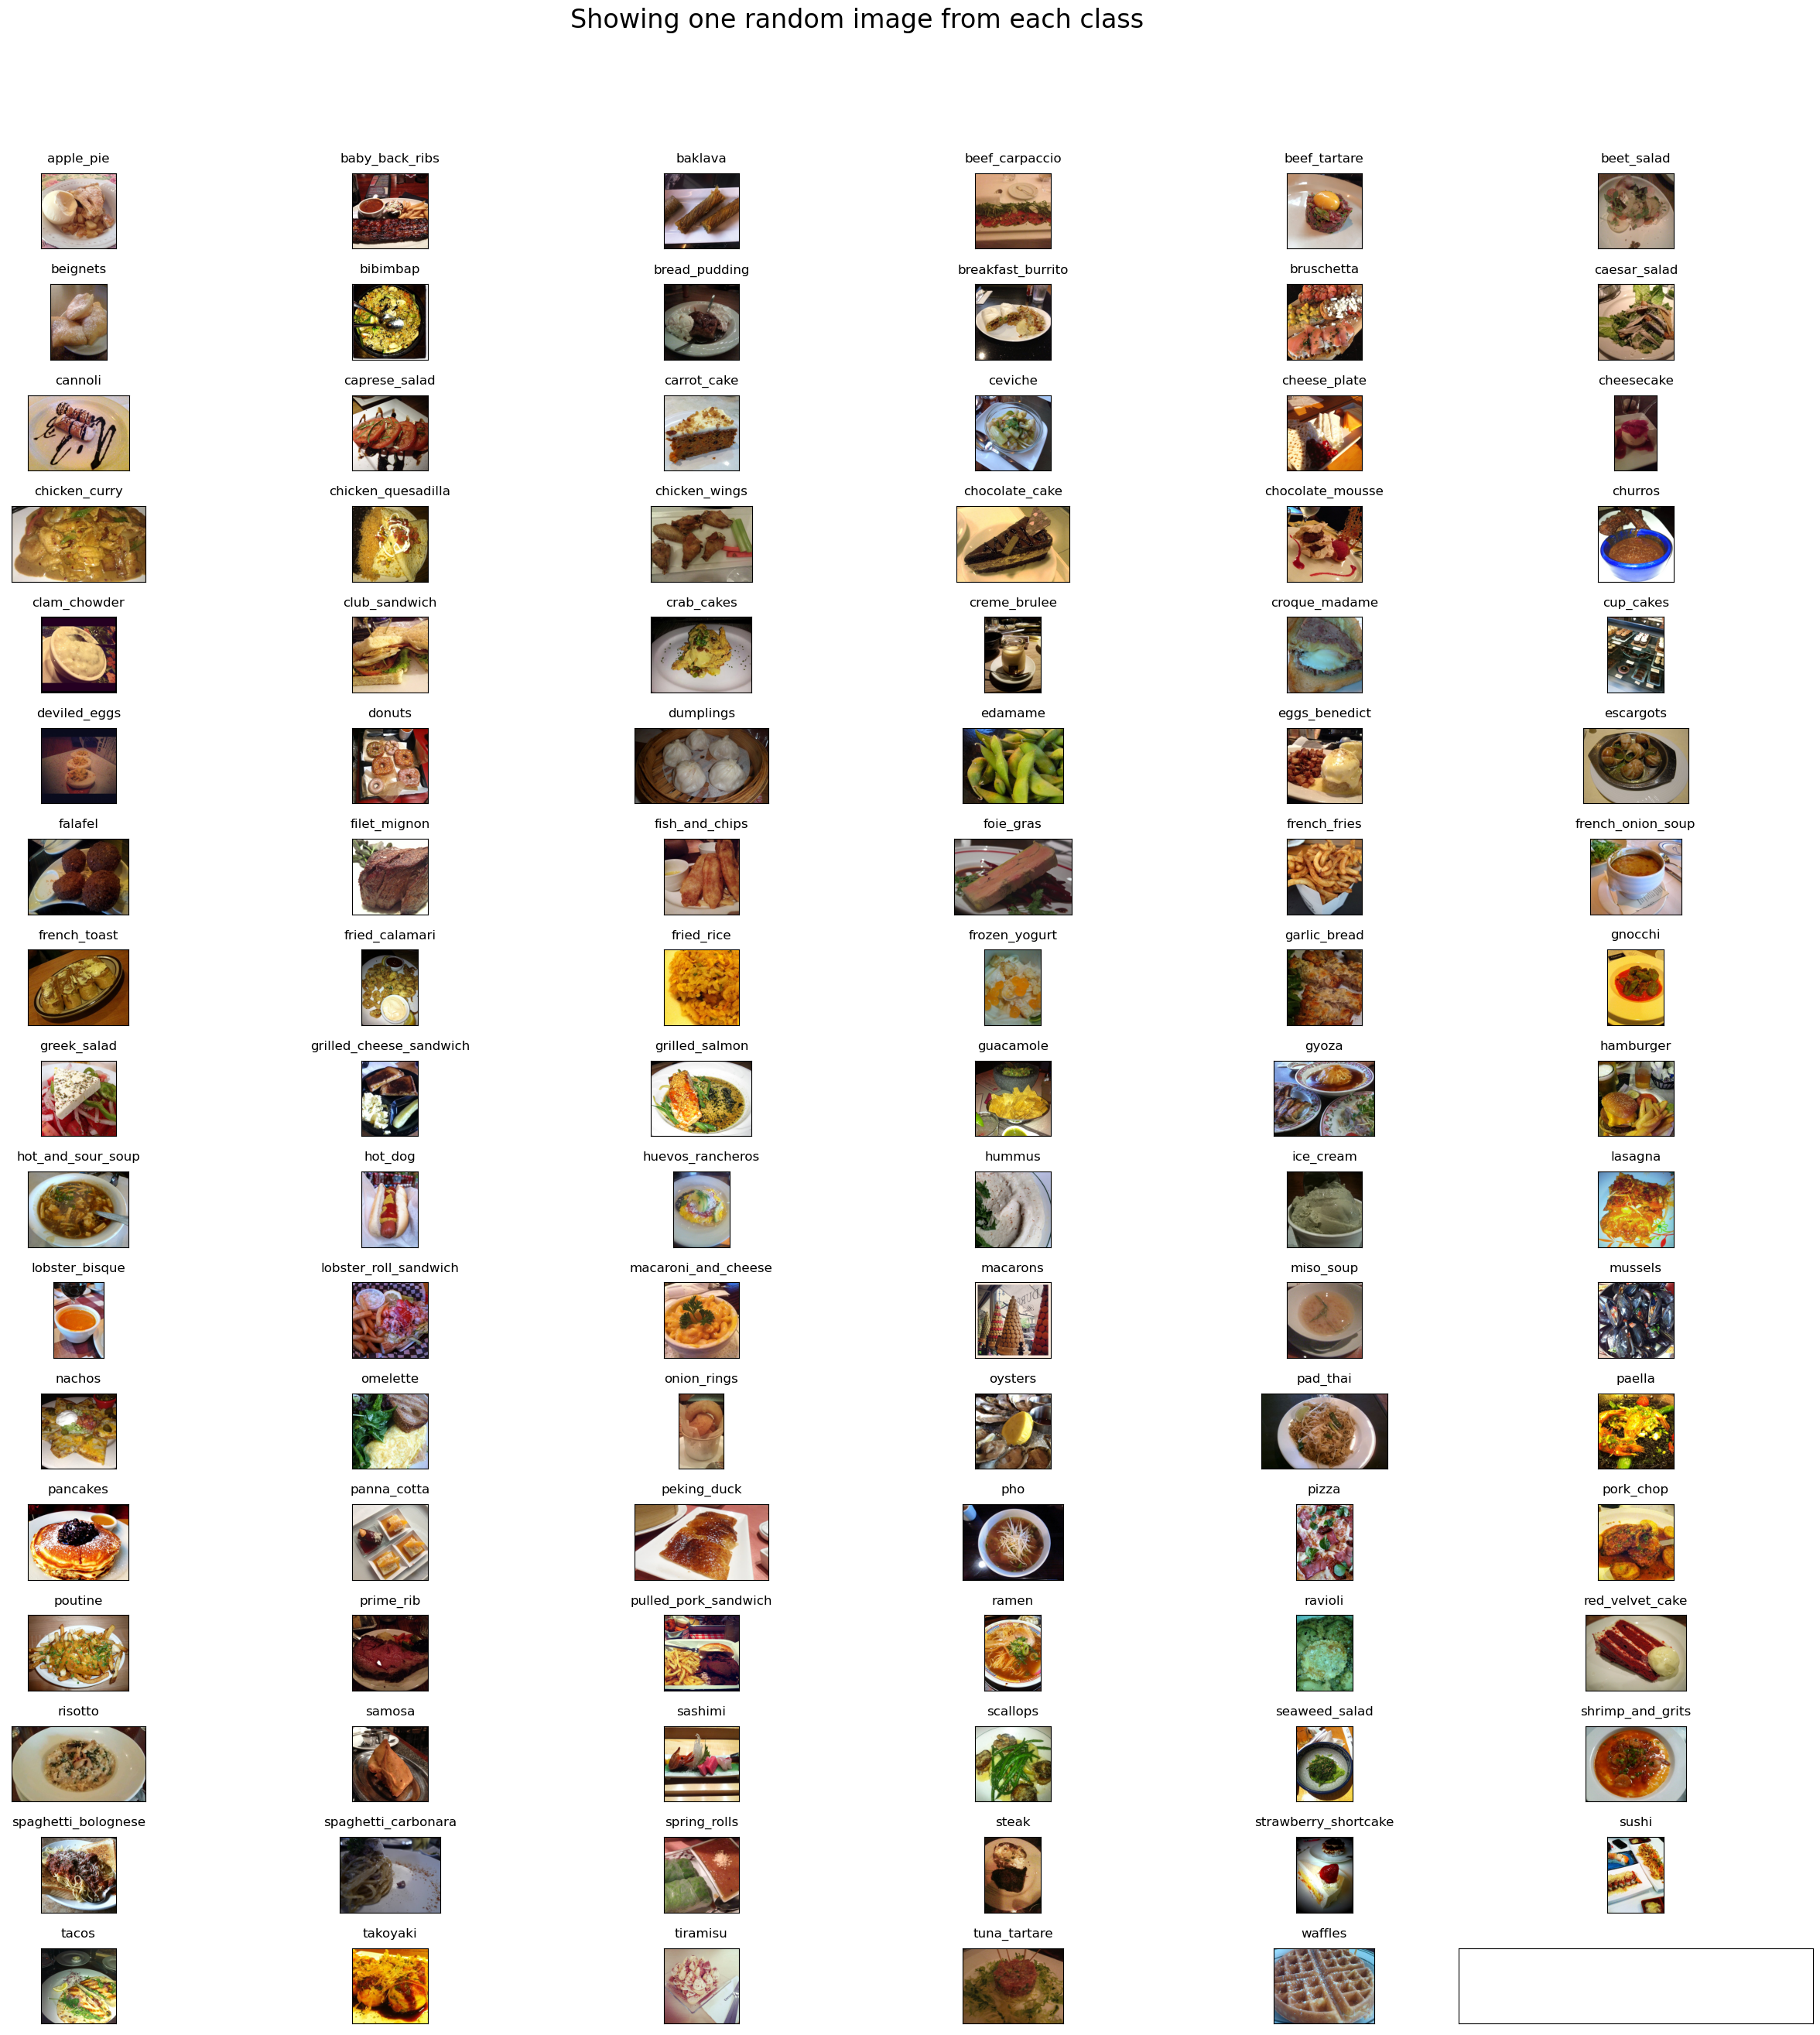

In [4]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [5]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [6]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [7]:
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

In [8]:
# Helper method to create train_mini and test_mini data samples
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [9]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [10]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [11]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [12]:
EXP_NAME = 'mini'

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

! pip install -U git+https://github.com/qubvel/efficientnet

In [14]:
import efficientnet.tfkeras as efn

In [15]:
K.clear_session()

n_classes = 3
img_width, img_height = 256, 256
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16
initial_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

base_model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
#optimizer = SGD(lr=0.0001, momentum=0.9)
optimizer = Adam(lr=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


C:\Users\dv\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 48  192         ['stem_conv[0][0]']              
                                )                                                             

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 64, 64, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 64, 64, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 64, 64, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 64, 64, 192)  0           ['block2c_activation[0][0]',     
          

 block3a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 32, 32, 56)   10752       ['block3a_se_excite[0][0]']      
                                                                                                  
 block3a_project_bn (BatchNorma  (None, 32, 32, 56)  224         ['block3a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 32, 32, 56)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 32, 32, 56)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 32, 32, 336)  18816       ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 32, 32, 336)  1344       ['block3d_expand_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 16, 16, 672)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4b_dwconv[0][0]']         
 )                                                                                                
          

 block4d_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 16, 16, 672)  0          ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 672)         0           ['block4d_activation[0][0]']     
 agePoolin

                                                                                                  
 block4f_activation (Activation  (None, 16, 16, 672)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 672)         0           ['block4f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4f_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block4f_se_squeeze[0][0]']     
                                                                                                  
 block4f_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block4f_se_reshape[0][0]']     
          

                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block5d_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 16, 16, 160)  0           ['block5d_drop[0][0]',           
                                                                  'block5c_add[0][0]']            
          

                                                                                                  
 block5f_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 16, 16, 160)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 16, 16, 960)  153600      ['block5f_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 16, 16, 960)  3840       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6c_expand_activation (Act  (None, 8, 8, 1632)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 8, 8, 1632)  40800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6c_a

 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 8, 8, 1632)  0           ['block6e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 1632)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block6g_activation (Activation  (None, 8, 8, 1632)  0           ['block6g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 1632)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block6g_se_reshape[0][0]']     
                                                                                                  
 block6g_s

                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1632)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_p

In [16]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback])

model.save('model_trained_3class.hdf5')

C:\Users\dv\AppData\Local\Temp\ipykernel_1812\2389766577.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
140/140 [==============================] - 105s 683ms/step - loss: 0.7084 - accuracy: 0.7269 - val_loss: 0.3917 - val_accuracy: 0.8845
Epoch 2/10
140/140 [==============================] - 94s 670ms/step - loss: 0.4483 - accuracy: 0.8438 - val_loss: 0.3086 - val_accuracy: 0.9022
Epoch 3/10
140/140 [==============================] - 96s 687ms/step - loss: 0.3853 - accuracy: 0.8697 - val_loss: 0.2838 - val_accuracy: 0.9076
Epoch 4/10
140/140 [==============================] - 92s 656ms/step - loss: 0.3663 - accuracy: 0.8724 - val_loss: 0.2709 - val_accuracy: 0.9076
Epoch 5/10
140/140 [==============================] - 99s 709ms/step - loss: 0.3447 - accuracy: 0.8796 - val_loss: 0.2554 - val_accuracy: 0.9280
Epoch 6/10
140/140 [==============================] - 97s 694ms/step - loss: 0.3138 - accuracy: 0.8939 - val_loss: 0.2440 - val_accuracy: 0.9239
Epoch 7/10
140/140 [==============================] - 91s 648ms/step - loss: 0.3102 - accuracy: 0.8944 - val_loss: 0.2412 - val_a

In [17]:
%%time

model.evaluate(validation_generator)

47/47 [==============================] - 22s 468ms/step - loss: 0.2292 - accuracy: 0.9387
Wall time: 22.1 s


[0.22917048633098602, 0.9386666417121887]

In [18]:
base_model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  467


In [20]:
len(model.trainable_variables)

64

In [21]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    verbose=1,
                    callbacks=[tensorboard_callback])

C:\Users\dv\AppData\Local\Temp\ipykernel_1812\498319661.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine = model.fit_generator(train_generator,


Epoch 10/20
140/140 [==============================] - 94s 670ms/step - loss: 0.2751 - accuracy: 0.9073 - val_loss: 0.2327 - val_accuracy: 0.9361
Epoch 11/20
140/140 [==============================] - 96s 687ms/step - loss: 0.2628 - accuracy: 0.9114 - val_loss: 0.2331 - val_accuracy: 0.9293
Epoch 12/20
140/140 [==============================] - 96s 683ms/step - loss: 0.2635 - accuracy: 0.9096 - val_loss: 0.2211 - val_accuracy: 0.9361
Epoch 13/20
140/140 [==============================] - 101s 719ms/step - loss: 0.2530 - accuracy: 0.9154 - val_loss: 0.2226 - val_accuracy: 0.9389
Epoch 14/20
140/140 [==============================] - 103s 733ms/step - loss: 0.2538 - accuracy: 0.9185 - val_loss: 0.2262 - val_accuracy: 0.9293
Epoch 15/20
140/140 [==============================] - 92s 657ms/step - loss: 0.2490 - accuracy: 0.9154 - val_loss: 0.2166 - val_accuracy: 0.9402
Epoch 16/20
140/140 [==============================] - 95s 681ms/step - loss: 0.2466 - accuracy: 0.9150 - val_loss: 0.2149

In [22]:
%%time

model.evaluate(validation_generator)

47/47 [==============================] - 22s 461ms/step - loss: 0.2184 - accuracy: 0.9280
Wall time: 21.8 s


[0.21836678683757782, 0.9279999732971191]

In [23]:
EXP_NAME = 'full'

In [24]:
K.clear_session()

n_classes = 101
img_width, img_height = 256, 256
train_data_dir = 'food-101/train'
validation_data_dir = 'food-101/test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 16
initial_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

base_model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
#optimizer = SGD(lr=0.0001, momentum=0.9)
optimizer = Adam(lr=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 48  192         ['stem_conv[0][0]']              
    

 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 64, 64, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 64, 64, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 64, 64, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_s

                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 32, 32, 56)   10752       ['block3a_se_excite[0][0]']      
                                                                                                  
 block3a_p

 block3c_project_bn (BatchNorma  (None, 32, 32, 56)  224         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 32, 32, 56)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 32, 32, 56)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 32, 32, 336)  18816       ['block3c_add[0][0]']            
                                                                                                  
 block3d_e

 block4b_expand_bn (BatchNormal  (None, 16, 16, 672)  2688       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 16, 16, 672)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4b_dwconv[0][0]']         
 )        

                                                                                                  
 block4d_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 16, 16, 672)  0          ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_s

 )                                                                                                
                                                                                                  
 block4f_activation (Activation  (None, 16, 16, 672)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 672)         0           ['block4f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4f_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block4f_se_squeeze[0][0]']     
                                                                                                  
 block4f_s

 block5b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5b_project_conv[0][0]']   
 lization)

                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 16, 16, 160)  0           ['block5d_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block5f_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 16, 16, 160)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 16, 16, 960)  153600      ['block5f_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 16, 16, 960)  3840       ['block6a_expand_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 8, 8, 1632)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 8, 8, 1632)  40800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6c_dwconv[0][0]']         
 )                                                                                                
          

 block6e_dwconv (DepthwiseConv2  (None, 8, 8, 1632)  40800       ['block6e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 8, 8, 1632)  0           ['block6e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 1632)        0           ['block6e_activation[0][0]']     
 agePoolin

                                                                                                  
 block6g_activation (Activation  (None, 8, 8, 1632)  0           ['block6g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 1632)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block6g_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1632)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
          

In [25]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback])

model.save('model_trained_101class.hdf5')

C:\Users\dv\AppData\Local\Temp\ipykernel_1812\3021302102.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
4734/4734 [==============================] - 3276s 690ms/step - loss: 3.7928 - accuracy: 0.2384 - val_loss: 2.6959 - val_accuracy: 0.4550
Epoch 2/10
4734/4734 [==============================] - 3294s 696ms/step - loss: 3.0173 - accuracy: 0.3566 - val_loss: 2.3401 - val_accuracy: 0.5118
Epoch 3/10
4734/4734 [==============================] - 2846s 601ms/step - loss: 2.7881 - accuracy: 0.3924 - val_loss: 2.1679 - val_accuracy: 0.5375
Epoch 4/10
4734/4734 [==============================] - 2875s 607ms/step - loss: 2.6508 - accuracy: 0.4166 - val_loss: 2.0589 - val_accuracy: 0.5541
Epoch 5/10
4734/4734 [==============================] - 2891s 611ms/step - loss: 2.5587 - accuracy: 0.4290 - val_loss: 1.9820 - val_accuracy: 0.5655
Epoch 6/10
4734/4734 [==============================] - 2884s 609ms/step - loss: 2.4949 - accuracy: 0.4407 - val_loss: 1.9243 - val_accuracy: 0.5736
Epoch 7/10
4734/4734 [==============================] - 2862s 604ms/step - loss: 2.4436 - accuracy: 0.4472

In [26]:
%%time

model.evaluate(validation_generator)

1579/1579 [==============================] - 630s 399ms/step - loss: 1.7859 - accuracy: 0.5971
Wall time: 10min 29s


[1.7859368324279785, 0.5971089005470276]

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  467


In [29]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 48  192         ['stem_conv[0][0]']              
                                )                                                             

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 64, 64, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 64, 64, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 64, 64, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 64, 64, 192)  0           ['block2c_activation[0][0]',     
          

 block3a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 32, 32, 192)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 32, 32, 56)   10752       ['block3a_se_excite[0][0]']      
                                                                                                  
 block3a_project_bn (BatchNorma  (None, 32, 32, 56)  224         ['block3a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 32, 32, 56)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 32, 32, 56)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 32, 32, 336)  18816       ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 32, 32, 336)  1344       ['block3d_expand_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 16, 16, 672)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4b_dwconv[0][0]']         
 )                                                                                                
          

 block4d_dwconv (DepthwiseConv2  (None, 16, 16, 672)  6048       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 16, 16, 672)  2688       ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 16, 16, 672)  0          ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 672)         0           ['block4d_activation[0][0]']     
 agePoolin

                                                                                                  
 block4f_activation (Activation  (None, 16, 16, 672)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 672)         0           ['block4f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4f_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block4f_se_squeeze[0][0]']     
                                                                                                  
 block4f_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block4f_se_reshape[0][0]']     
          

                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block5d_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_add (Add)              (None, 16, 16, 160)  0           ['block5d_drop[0][0]',           
                                                                  'block5c_add[0][0]']            
          

                                                                                                  
 block5f_drop (FixedDropout)    (None, 16, 16, 160)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 16, 16, 160)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 16, 16, 960)  153600      ['block5f_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 16, 16, 960)  3840       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6c_expand_activation (Act  (None, 8, 8, 1632)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 8, 8, 1632)  40800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6c_a

 D)                                                              ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 8, 8, 1632)  6528        ['block6e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6e_activation (Activation  (None, 8, 8, 1632)  0           ['block6e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6e_se_squeeze (GlobalAver  (None, 1632)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block6g_activation (Activation  (None, 8, 8, 1632)  0           ['block6g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6g_se_squeeze (GlobalAver  (None, 1632)        0           ['block6g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block6g_se_reshape[0][0]']     
                                                                                                  
 block6g_s

                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1632)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 68)     111044      ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1632)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_p

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    verbose=1,
                    callbacks=[tensorboard_callback])

C:\Users\dv\AppData\Local\Temp\ipykernel_1812\498319661.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine = model.fit_generator(train_generator,


Epoch 10/20
4734/4734 [==============================] - 3595s 757ms/step - loss: 2.1067 - accuracy: 0.5109 - val_loss: 1.2469 - val_accuracy: 0.7081
Epoch 11/20
4734/4734 [==============================] - 3535s 747ms/step - loss: 1.7267 - accuracy: 0.5951 - val_loss: 1.0945 - val_accuracy: 0.7415
Epoch 12/20
4734/4734 [==============================] - 3532s 746ms/step - loss: 1.5446 - accuracy: 0.6341 - val_loss: 1.0110 - val_accuracy: 0.7572
Epoch 13/20
4734/4734 [==============================] - 3535s 747ms/step - loss: 1.4077 - accuracy: 0.6638 - val_loss: 0.9707 - val_accuracy: 0.7686
Epoch 14/20
4734/4734 [==============================] - 3533s 746ms/step - loss: 1.2982 - accuracy: 0.6869 - val_loss: 0.9305 - val_accuracy: 0.7778
Epoch 15/20
4734/4734 [==============================] - 3566s 753ms/step - loss: 1.2031 - accuracy: 0.7096 - val_loss: 0.9151 - val_accuracy: 0.7809
Epoch 16/20
4734/4734 [==============================] - 3528s 745ms/step - loss: 1.1250 - accuracy:

In [31]:
%%time

model.evaluate(validation_generator)

1579/1579 [==============================] - 635s 402ms/step - loss: 0.9190 - accuracy: 0.7881
Wall time: 10min 35s


[0.9190385937690735, 0.7880792021751404]

In [32]:
%load_ext tensorboard
%tensorboard --logdir logs